##### Copyright 2020 The TensorFlow IO Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 색 공간 변환

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/io/tutorials/colorspace"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/io/tutorials/colorspace.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행하기</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/io/tutorials/colorspace.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서소스 보기</a></td>
      <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/io/tutorials/colorspace.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드하기</a></td>
</table>

## 개요

컴퓨터 비전에서 선택한 색 공간은 모델의 성능에 상당한 영향을 미칠 수 있습니다. `RGB`가 가장 일반적인 색 공간이지만 많은 상황에서 `YUV`, `YCbCr`, `XYZ (CIE)` 등과 같은 대체 색 공간으로 전환할 때 모델이 더 잘 동작합니다.

`tensorflow-io` 패키지는 이미지 데이터를 준비하고 보강하는 데 사용할 수 있는 일련의 색 공간 변환 API를 제공합니다.

## 설정

### 필수 패키지를 설치하고 런타임 다시 시작하기

In [2]:
!pip install -q tensorflow-io

### 샘플 이미지 다운로드하기

이 튜토리얼에 사용된 이미지 예는 [눈 속의 고양이](https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg)이지만 어떤 JPEG 이미지로든 대체할 수 있습니다.

다음을 이용해 이미지를 다운로드하고 로컬 디스크에 `sample.jpg`로 저장합니다.

In [3]:
!curl -o sample.jpg -L https://storage.googleapis.com/download.tensorflow.org/example_images/320px-Felis_catus-cat_on_snow.jpg

!ls -ls sample.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100 17858  100 17858    0     0  94486      0 --:--:-- --:--:-- --:--:-- 94486


20 -rw-rw-r-- 1 kbuilder kokoro 17858 Nov 12 02:20 sample.jpg


## 사용법

### 이미지 파일 읽기

이미지를 읽고 형상 `(213, 320, 3)`의 `uint8` 텐서로 디코딩합니다.

In [4]:
import tensorflow as tf
import tensorflow_io as tfio

image = tf.image.decode_jpeg(tf.io.read_file('sample.jpg'))

print(image.shape, image.dtype)

(213, 320, 3) <dtype: 'uint8'>


다음을 이용해 이미지를 표시할 수 있습니다.

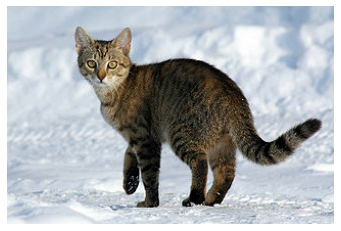

In [5]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(image)
plt.axis('off')
plt.show()

### RGB를 그레이스케일로 변환하기

`tfio.experimental.color.rgb_to_grayscale`를 이용해 <code>RGB</code> 이미지를 `Grayscale`로 변환하여 채널을 3개에서 1개로 줄일 수 있습니다.

(213, 320, 1) <dtype: 'uint8'>


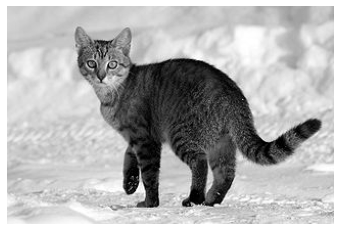

In [6]:
grayscale = tfio.experimental.color.rgb_to_grayscale(image)

print(grayscale.shape, grayscale.dtype)

# use tf.squeeze to remove last channel for plt.imshow to display:
plt.figure()
plt.imshow(tf.squeeze(grayscale, axis=-1), cmap='gray')
plt.axis('off')
plt.show()

### RGB를 BGR로 변환하기

일부 이미지 소프트웨어 및 카메라 제조업체는 `tfio.experimental.color.rgb_to_bgr`을 통해 얻을 수 있는 `BGR`을 선호할 수 있습니다.

(213, 320, 3) <dtype: 'uint8'>


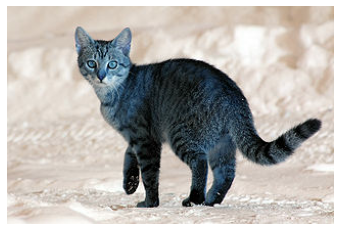

In [7]:
bgr = tfio.experimental.color.rgb_to_bgr(image)

print(bgr.shape, bgr.dtype)

plt.figure()
plt.imshow(bgr)
plt.axis('off')
plt.show()

### RGB를 CIE XYZ로 변환하기

`CIE XYZ`(또는 `CIE 1931 XYZ`)는 많은 이미지 처리 프로그램에서 사용되는 일반적인 색 공간입니다. 다음은 `tfio.experimental.color.rgb_to_xyz`를 이용해 RGB에서 `CIE XYZ`로 변환하는 작업입니다. `tfio.experimental.color.rgb_to_xyz`는 `[0, 1]` 범위에서 부동 소수점 입력을 가정하므로 추가적인 전처리가 필요합니다.

(213, 320, 3) <dtype: 'uint8'>


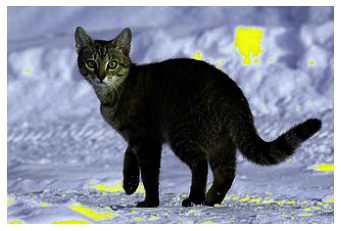

In [8]:
# convert to float32
image_float32 = tf.cast(image, tf.float32) / 255.0

xyz_float32 = tfio.experimental.color.rgb_to_xyz(image_float32)

# convert back uint8
xyz = tf.cast(xyz_float32 * 255.0, tf.uint8)

print(xyz.shape, xyz.dtype)

plt.figure()
plt.imshow(xyz)
plt.axis('off')
plt.show()

### RGB를 YCbCr로 변환하기

마지막으로, `YCbCr`은 많은 비디오 시스템에서 사용되는 기본 색 공간입니다. `tfio.experimental.color.rgb_to_ycbcr`을 이용해 `YCbCr`로 변환할 수 있습니다.

(213, 320, 3) <dtype: 'uint8'>


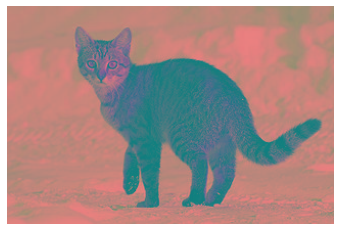

In [9]:
ycbcr = tfio.experimental.color.rgb_to_ycbcr(image)

print(ycbcr.shape, ycbcr.dtype)

plt.figure()
plt.imshow(ycbcr, cmap='gray')
plt.axis('off')
plt.show()

하지만 더 흥미로운 점은 `YCbCr`을 `Y'`(루마), `Cb`(청색 차이 채도) 및 `Cr`(적색 차이 채도) 성분으로 분해할 수 있다는 것입니다. 각 성분은 지각적으로 의미 있는 정보를 전달합니다.

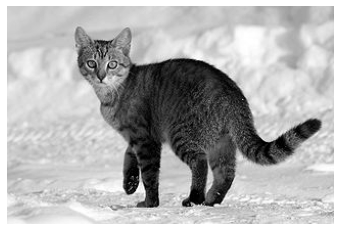

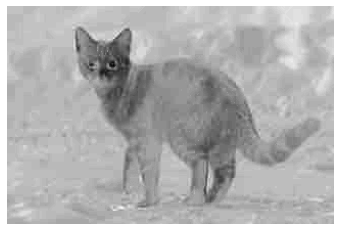

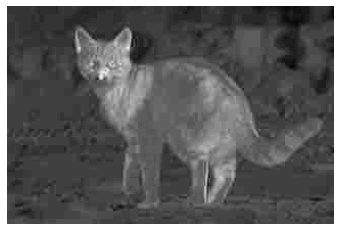

In [10]:
y, cb, cr = ycbcr[:,:,0], ycbcr[:,:,1], ycbcr[:,:,2]

# Y' component
plt.figure()
plt.imshow(y, cmap='gray')
plt.axis('off')
plt.show()

# Cb component
plt.figure()
plt.imshow(cb, cmap='gray')
plt.axis('off')
plt.show()

# Cr component
plt.figure()
plt.imshow(cr, cmap='gray')
plt.axis('off')
plt.show()